<a href="https://colab.research.google.com/github/julurisaichandu/face_recognition/blob/main/Face_recognition_in_the_wild.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/faces.zip

Archive:  /content/drive/MyDrive/faces.zip
  inflating: Celebrity Faces Dataset/Angelina Jolie/001_fe3347c0.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/002_8f8da10e.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/003_57612506.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/004_f61e7d0c.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/005_582c121a.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/006_9135205d.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/007_cabbfcbb.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/008_d1f87068.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/009_fb3e6174.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/010_f99d79e3.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/011_7344ca35.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/012_cfcd4007.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/013_95ecbd39.jpg  
  inflating: Celebrity Faces Datas

In [ ]:
#Rename Celebrity Faces Dataset to CFD and then proceed to run the below cell

In [ ]:
dataset_path = '/content/Celebrity Faces Dataset'


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_and_split_dataset(dataset_path, test_size=0.2, val_size=0.25):
    images = []
    labels = []
    label_names = os.listdir(dataset_path)
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(label_names)
    label_map = dict(zip(label_encoder.classes_, encoded_labels))

    for label in label_names:
        class_path = os.path.join(dataset_path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))
            images.append(img.flatten())
            labels.append(label_map[label])

    images = np.array(images)
    labels = np.array(labels)

    X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=test_size, stratify=labels, random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=42)  # 0.25 x 0.8 = 0.2

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = load_and_split_dataset(dataset_path)

print(f'Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}, Test size: {X_test.shape[0]}')


Train size: 1080, Validation size: 360, Test size: 360


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


svm_classifier = SVC(kernel='linear', C=0.2, random_state=42)

svm_classifier.fit(X_train, y_train)

y_val_pred = svm_classifier.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')


Validation Accuracy: 0.25833333333333336


In [ ]:
y_test_pred = svm_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Test Accuracy: 0.19722222222222222
                    precision    recall  f1-score   support

    Angelina Jolie       0.27      0.30      0.29        20
         Brad Pitt       0.04      0.05      0.04        20
 Denzel Washington       0.13      0.15      0.14        20
      Hugh Jackman       0.12      0.10      0.11        20
 Jennifer Lawrence       0.05      0.05      0.05        20
       Johnny Depp       0.18      0.15      0.16        20
      Kate Winslet       0.31      0.45      0.37        20
 Leonardo DiCaprio       0.16      0.15      0.15        20
         Megan Fox       0.00      0.00      0.00        20
   Natalie Portman       0.24      0.20      0.22        20
     Nicole Kidman       0.20      0.15      0.17        20
  Robert Downey Jr       0.11      0.10      0.11        20
    Sandra Bullock       0.48      0.62      0.54        40
Scarlett Johansson       0.09      0.10      0.09        20
        Tom Cruise       0.11      0.10      0.10        20
    

CNN based model

In [ ]:
!mkdir 'new_CFD'

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_dataset_path = '/content/Celebrity Faces Dataset'
target_dataset_path = '/content/new_CFD'

for split in ['train', 'val']:
    os.makedirs(os.path.join(target_dataset_path, split), exist_ok=True)

celebrities = os.listdir(original_dataset_path)
for celeb in celebrities:
    images = os.listdir(os.path.join(original_dataset_path, celeb))
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for split, image_list in [('train', train_imgs), ('val', val_imgs)]:
        dir_path = os.path.join(target_dataset_path, split, celeb)
        os.makedirs(dir_path, exist_ok=True)

        for img in image_list:
            src = os.path.join(original_dataset_path, celeb, img)
            dst = os.path.join(dir_path, img)
            shutil.copy(src, dst)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
data_dir = 'new_CFD'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=18):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.dropout = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(128 * 28 * 28, 512)
#         self.fc2 = nn.Linear(512, num_classes)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = self.pool(self.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 28 * 28)
#         x = self.dropout(x)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=18):
        super(AdvancedCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Calculate correct input size
        # Assume input image size is 224 x 224
        size = 224
        layers = 5  # Total pooling layers
        for _ in range(layers):
            size = size // 2  # each max pooling operation halves the dimension
        print(f"Expected size after all layers: {size}x{size}")

        self.fc1 = nn.Linear(512 * size * size, 1024)  # Adjust the size here
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the dense layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Assuming usage of GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedCNN().to(device)
print(model)


Expected size after all layers: 7x7
AdvancedCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [ ]:
# model = SimpleCNN(num_classes=len(class_names)).to(device)
model = AdvancedCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Expected size after all layers: 7x7


In [ ]:
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / dataset_sizes['train']

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')



Epoch 1/500, Loss: 2.9114
Epoch 2/500, Loss: 2.6150
Epoch 3/500, Loss: 2.5083
Epoch 4/500, Loss: 2.4882
Epoch 5/500, Loss: 2.4384
Epoch 6/500, Loss: 2.3787
Epoch 7/500, Loss: 2.3224
Epoch 8/500, Loss: 2.2834
Epoch 9/500, Loss: 2.2568
Epoch 10/500, Loss: 2.2120
Epoch 11/500, Loss: 2.1901
Epoch 12/500, Loss: 2.1517
Epoch 13/500, Loss: 2.1220
Epoch 14/500, Loss: 2.1089
Epoch 15/500, Loss: 2.0581
Epoch 16/500, Loss: 2.0432
Epoch 17/500, Loss: 2.0548
Epoch 18/500, Loss: 1.9887
Epoch 19/500, Loss: 2.0280
Epoch 20/500, Loss: 1.9413
Epoch 21/500, Loss: 1.9225
Epoch 22/500, Loss: 1.9175
Epoch 23/500, Loss: 1.9256
Epoch 24/500, Loss: 1.8818
Epoch 25/500, Loss: 1.8775
Epoch 26/500, Loss: 1.8375
Epoch 27/500, Loss: 1.8690
Epoch 28/500, Loss: 1.8521
Epoch 29/500, Loss: 1.8613
Epoch 30/500, Loss: 1.7947
Epoch 31/500, Loss: 1.8353
Epoch 32/500, Loss: 1.7658
Epoch 33/500, Loss: 1.7425
Epoch 34/500, Loss: 1.7096
Epoch 35/500, Loss: 1.7381
Epoch 36/500, Loss: 1.7650
Epoch 37/500, Loss: 1.7398
Epoch 38/5

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def evaluate_model(model, dataloaders, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=False)
    return accuracy, report


In [ ]:
accuracy, report = evaluate_model(model, dataloaders, device)
print(f"Validation Accuracy: {accuracy:.4f}")
print(report)


In [ ]:
def evaluate_model(model, dataloaders, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=False)
    return accuracy, report, all_labels, all_preds


In [ ]:
accuracy, report, all_labels, all_preds = evaluate_model(model, dataloaders, device)
print(f"Validation Accuracy: {accuracy:.4f}")
print(report)

plot_confusion_matrix(all_labels, all_preds, class_names)


Vision Transformer implementation begins here!

In [ ]:
pip install torch torchvision timm matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00


In [ ]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}


In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_dir = '/content/new_CFD'
batch_size = 8

datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x])
            for x in ['train', 'val']}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes


In [ ]:
print(class_names)

['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


In [ ]:
import timm
import torch.nn as nn
checkpoint = "/content/drive/MyDrive/107_trained_model.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_base_patch16_224', checkpoint_path=checkpoint)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


RuntimeError: Error(s) in loading state_dict for VisionTransformer:
	size mismatch for head.weight: copying a param with shape torch.Size([17, 768]) from checkpoint, the shape in current model is torch.Size([1000, 768]).
	size mismatch for head.bias: copying a param with shape torch.Size([17]) from checkpoint, the shape in current model is torch.Size([1000]).

In [ ]:
import timm
import torch.nn as nn

checkpoint = "/content/drive/MyDrive/107_trained_model.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Replace the classifier head
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, len(class_names))  # Assuming class_names is defined elsewhere

# Load the state dict of the saved model
checkpoint = torch.load(checkpoint)

# Load the state dict into the model
model.load_state_dict(checkpoint)

# Move the model to the appropriate device
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [ ]:
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / dataset_sizes['train']}")




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/300, Loss: 0.4939724855616482
Epoch 2/300, Loss: 0.4440697302007013
Epoch 3/300, Loss: 0.4311883173624261
Epoch 4/300, Loss: 0.45381955580992833
Epoch 5/300, Loss: 0.3971321801499774
Epoch 6/300, Loss: 0.41353776419224836
Epoch 7/300, Loss: 0.38806008600707476
Epoch 8/300, Loss: 0.4687824358128839
Epoch 9/300, Loss: 0.4384040545077167
Epoch 10/300, Loss: 0.446966510233728
Epoch 11/300, Loss: 0.40046712912800203
Epoch 12/300, Loss: 0.407041068504461
Epoch 13/300, Loss: 0.39644740435243064
Epoch 14/300, Loss: 0.4276031068526208
Epoch 15/300, Loss: 0.41344603876479796
Epoch 16/300, Loss: 0.38315565805985696
Epoch 17/300, Loss: 0.4250319731576989
Epoch 18/300, Loss: 0.407687908572714
Epoch 19/300, Loss: 0.4018062686392417
Epoch 20/300, Loss: 0.45240817138821715
Epoch 21/300, Loss: 0.39138622756193703
Epoch 22/300, Loss: 0.3772307719103992
Epoch 23/300, Loss: 0.39565779122317
Epoch 24/300, Loss: 0.3517662648784204
Epoch 25/300, Loss: 0.38395507965469733
Epoch 26/300, Loss: 0.3606003

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/158_trained_model.pth')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def evaluate(model, dataloaders, device):
    model.eval()
    corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = corrects.double() / total
    print(f'Accuracy: {accuracy:.4f}')

    print(classification_report(all_labels, all_preds, target_names=class_names))

    return all_labels, all_preds


In [ ]:
all_labels, all_preds = evaluate(model, dataloaders, device)


Accuracy: 0.4417
                    precision    recall  f1-score   support

    Angelina Jolie       0.31      0.40      0.35        20
         Brad Pitt       0.39      0.45      0.42        20
 Denzel Washington       0.36      0.40      0.38        20
      Hugh Jackman       0.60      0.45      0.51        20
 Jennifer Lawrence       0.33      0.20      0.25        20
       Johnny Depp       0.20      0.15      0.17        20
      Kate Winslet       0.36      0.20      0.26        20
 Leonardo DiCaprio       0.21      0.15      0.18        20
         Megan Fox       0.57      0.60      0.59        20
   Natalie Portman       0.33      0.35      0.34        20
     Nicole Kidman       0.69      0.55      0.61        20
  Robert Downey Jr       0.32      0.55      0.41        20
    Sandra Bullock       0.33      0.40      0.36        20
Scarlett Johansson       0.70      0.97      0.81        40
        Tom Cruise       0.40      0.30      0.34        20
         Tom Hanks    

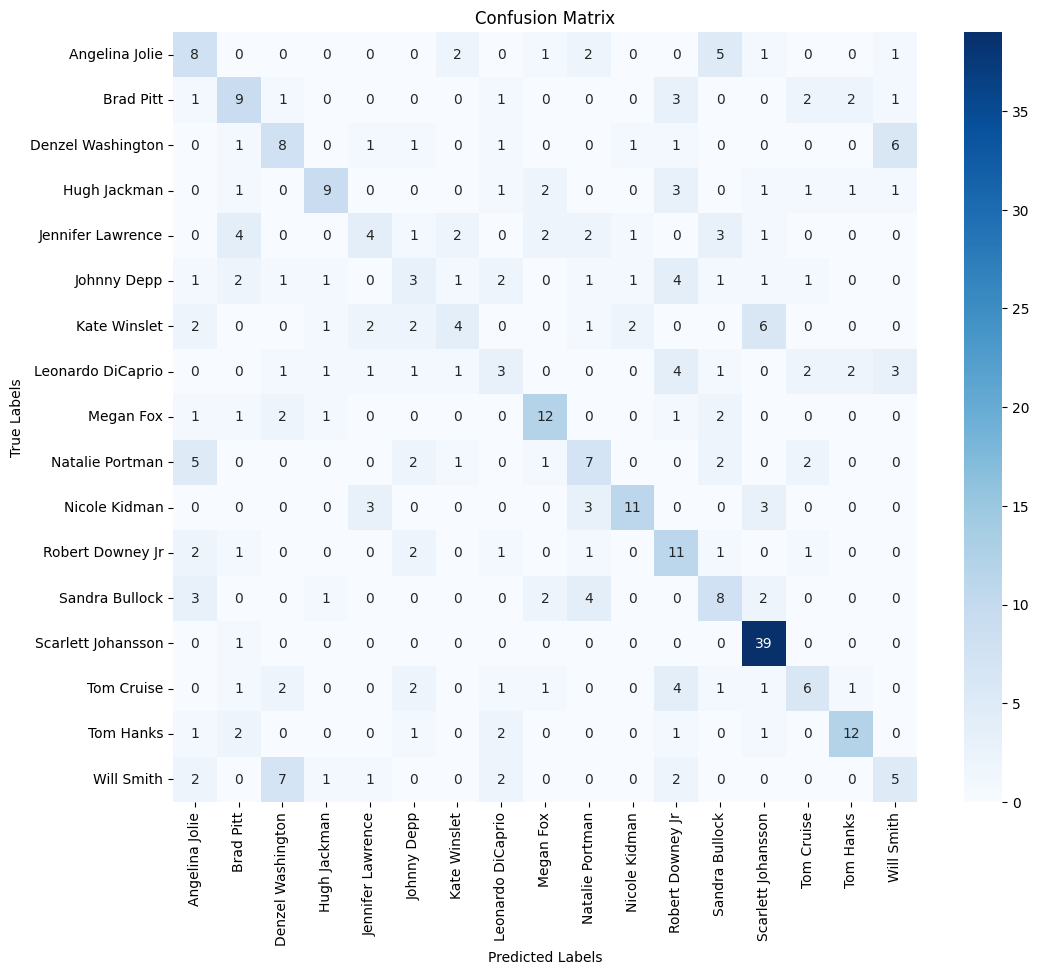

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(all_labels, all_preds, class_names)


In [ ]:
#testing

In [ ]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from skimage.feature import hog

def load_images_and_labels(base_path, image_size=(64, 64)):
    images = []
    labels = []
    label_names = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    label_map = {name: idx for idx, name in enumerate(label_names)}

    for label in label_names:
        folder_path = os.path.join(base_path, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            img_feature = hog(img, orientations=8, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), visualize=False, multichannel=False)
            images.append(img_feature)
            labels.append(label_map[label])

    return np.array(images), np.array(labels), label_map

# Load data
X, y, label_map = load_images_and_labels('/content/Celebrity Faces Dataset')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define SVM Classifier with Grid Search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly']
}
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train, y_train)

# Evaluate the model
predictions = grid.predict(X_test)
print(classification_report(y_test, predictions, target_names=label_map.keys()))

# Display best parameters
print("Best parameters found:", grid.best_params_)


<ipython-input-19-7c8141408769>:22: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_feature = hog(img, orientations=8, pixels_per_cell=(16, 16),


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   0.2s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   0.2s
[CV] END .....................C=0.1, gamma=auto,